# Context Vector Analysis in LLMs: Clustering and Loglog Plot
## Workflow
1. Init: Model & Data
  - Load any complex LLM (like LLAMA) and analysis it's architecture
  - Get a dataset containing 2000 continuous sentences. Pick a book with specific genre, Love or Mystery.
2. Embedding Analysis
  - Now retrieve the sentence embedding by getting the last vector in the final transformer. Or the input to the Fully connected layer (as discussed in the meeting)
3. Similarity Analysis
  - Do the similar analysis as before.
  - Do clustering using the sentence embedding and count the number of sentences in each cluster. Add the number of sentence on each group as a sanity check.
4. Plotting
  - Save the count in a vector. Rearrange them, and plot the count in y-axis and matrix index in the x-axis.
  - Also plot the log log plot using the count matrix.
  - Fit the log log plot with linear line and get the slope.

### 1. Initialization
- Model load
- Data analysis

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.5 MB/s eta 0:00:00


In [10]:
from datasets import load_dataset

# Load BookCorpus dataset (Streaming Mode)
dataset = load_dataset("bookcorpus", split="train", streaming=True, trust_remote_code=True)

love_sentences = []

for example in iter(dataset):
    text = example["text"]  # Each example is a dictionary
    if "love" in text.lower() or "romance" in text.lower():
        sentences = text.split(". ")  # Split into sentences
        love_sentences.extend(sentences)

    if len(love_sentences) >= 3000:
        break  # Stop when 2000 sentences are collected

print(f"Collected {len(love_sentences)} sentences.")


Collected 3000 sentences.


In [11]:
import re

love_sentences = [re.sub(r'[^a-zA-Z0-9.,!? ]', '', s).strip() for s in love_sentences]
love_sentences = [s for s in love_sentences if 5 < len(s.split()) < 50]
final_sentences = love_sentences[:2000]

In [12]:
print(final_sentences)

['she d always loved how the dress made her feel sexy , but at the same time was very respectable .', 'she loved her newest cousin very much and planned to be the best godmother she could for him .', 'he loved them too much to be denied .', 'it was nt until she fell in love for the first time in her life that she threw everything away .', 'sadly , she could nt say that her first love was davis , mason s father .', 'he loved sitting between her brothers on the couch and watching tv .', 'aw , you love your godmother , do nt you noah ?', 'i could never , ever love another man like i do him', 'especially if the last woman he cared about loved someone else', 'nothing would make me happier than if you were to fall in love with pesh', 'i know i would love to work alongside someone who had your passion', 'thank god he loves his baths ,  aidan muttered beside pesh .', 'i love aidan , but he s not necessarily a gentleman .', 'and with a wink , he walked off to join emma , leaving megan to wonder

In [13]:
print(len(final_sentences))

2000


In [14]:
import json

with open("love_2000_sentences.json", "w", encoding="utf-8") as f:
    json.dump(final_sentences, f, indent=4)

- Load Existed Data

In [2]:
## load existed data
import json
filename = "/content/love_2000_sentences.json"

with open(filename, "r", encoding="utf-8") as f:
    love_sentences = json.load(f)

print(f"Loaded {len(love_sentences)} sentences from love_sentences.txt")
print(love_sentences[:5])

Loaded 2000 sentences from love_sentences.txt
['she d always loved how the dress made her feel sexy , but at the same time was very respectable .', 'she loved her newest cousin very much and planned to be the best godmother she could for him .', 'he loved them too much to be denied .', 'it was nt until she fell in love for the first time in her life that she threw everything away .', 'sadly , she could nt say that her first love was davis , mason s father .']


In [7]:
sentences = love_sentences

- Load Model
  - Case1: General sentence embedding: Sentence-Bert, RoBERTa
  - Case2: General transformer-based model for extracting features from different layer: BERT, RoBERTa
  - focus on next-word prediction or autoregressive modeling: GPT-based model

In [3]:
import torch
from transformers import BertTokenizer, BertModel

model_name = "bert-base-uncased"


tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name, output_hidden_states=True)
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [4]:
print(model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

### 2. Features in LLMs Analysis

In [5]:
## define the function that extracts Features

def get_features(sentence, model, tokenizer, layer_indices=[-1, -4]):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=128)

    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)  # Ensure hidden states are returned

    hidden_states = outputs.hidden_states  # Extract all hidden states

    # Extract final layer embedding (CLS token representation)
    final_layer_emb = hidden_states[layer_indices[0]][:, 0, :].squeeze(0).cpu().numpy()

    # Extract intermediate layer embedding (e.g., -4th layer)
    intermediate_layer_emb = hidden_states[layer_indices[1]][:, 0, :].squeeze(0).cpu().numpy()

    return final_layer_emb, intermediate_layer_emb

In [8]:
import numpy as np

batch_size = 32
num_batches = len(sentences) // batch_size + (len(sentences) % batch_size != 0)

final_embeddings = []
intermediate_embeddings = []

for i in range(num_batches):
    batch = sentences[i * batch_size: (i + 1) * batch_size]

    # Get embeddings from model
    batch_final_emb, batch_inter_emb = zip(*[get_features(sent, model, tokenizer) for sent in batch])

    final_embeddings.extend(batch_final_emb)
    intermediate_embeddings.extend(batch_inter_emb)

final_embeddings = np.array(final_embeddings)
intermediate_embeddings = np.array(intermediate_embeddings)

print("Final embedding shape:", final_embeddings.shape)
print("Intermediate embedding shape:", intermediate_embeddings.shape)

Final embedding shape: (2000, 768)
Intermediate embedding shape: (2000, 768)


### 3. Similarity Analysis
- Cosine Similarity-based Grouping

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

final_cos_similar = cosine_similarity(final_embeddings)
intermediate_cos_similar = cosine_similarity(intermediate_embeddings)

In [10]:
# Simple Greedy Approcah
def grouping(cos_similar, n, thres):
  groups = []
  visited = set()

  for i in range(n):
    if i in visited:
      continue

    group = [i]
    visited.add(i)

    for j in range(n):
      if j not in visited and cos_similar[i][j] >= thres:
        group.append(j)
        visited.add(j)

    groups.append(group)

  return groups


# graph-based grouping (connected componenets) - clustering
import networkx as nx

def graph_based_grouping(cos_similar, n, thres):
  graph = nx.Graph()

  graph.add_nodes_from(range(n))

  for i in range(n):
    for j in range(i+1, n):
      if cos_similar[i][j] >= thres:
        graph.add_edge(i, j)

  groups = [list(component) for component in nx.connected_components(graph)]

  return groups


# Clustering using DBSCAN
from sklearn.cluster import DBSCAN

def clustering_grouping(embedding, thres):
  eps = 1 - thres
  clustering = DBSCAN(eps=eps, min_samples=2, metric="cosine").fit(embedding)
  labels = clustering.labels_

  # print("The number of clusters:", len(set(labels))-(1 if -1 in labels else 0))

  groups = {}
  for idx, label in enumerate(labels):
    if label not in groups:
      groups[label] = []
    groups[label].append(idx)
  return list(groups.values())

In [16]:
print("Cosine Similarity")
print(np.round(final_cos_similar[:5, :5], 2))

Cosine Similarity
[[1.   0.89 0.85 0.83 0.85]
 [0.89 1.   0.89 0.86 0.87]
 [0.85 0.89 1.   0.89 0.84]
 [0.83 0.86 0.89 1.   0.88]
 [0.85 0.87 0.84 0.88 1.  ]]


In [19]:
n = len(sentences)
thres = 0.85

greedy_final = grouping(final_cos_similar, n, thres)
greedy_inter = grouping(intermediate_cos_similar, n, thres)

graph_final = graph_based_grouping(final_cos_similar, n, thres)
graph_inter = graph_based_grouping(intermediate_cos_similar, n, thres)


dbscan_final = clustering_grouping(final_embeddings, thres)
dbscan_inter = clustering_grouping(intermediate_embeddings, thres)

In [20]:
print(f"Greedy Clustering (Final Layer): {len(greedy_final)} clusters")
print(f"Greedy Clustering (Intermediate Layer): {len(greedy_inter)} clusters")

print(f"Graph-based Clustering (Final Layer): {len(graph_final)} clusters")
print(f"Graph-based Clustering (Intermediate Layer): {len(graph_inter)} clusters")

print(f"DBSCAN Clustering (Final Layer): {len(dbscan_final)} clusters")
print(f"DBSCAN Clustering (Intermediate Layer): {len(dbscan_inter)} clusters")

Greedy Clustering (Final Layer): 151 clusters
Greedy Clustering (Intermediate Layer): 111 clusters
Graph-based Clustering (Final Layer): 16 clusters
Graph-based Clustering (Intermediate Layer): 9 clusters
DBSCAN Clustering (Final Layer): 2 clusters
DBSCAN Clustering (Intermediate Layer): 2 clusters


- Count

In [22]:
def get_count(groups):
  group_counts = []
  word_counts = []

  for group in groups:
    group_counts.append(len(group))

    unique_words = set() # prevent duplicates
    for idx in group:
      unique_words.update(sentences[idx].split())
    word_counts.append(len(unique_words))
  return group_counts, word_counts # num of sentence per group, num of word per group

In [23]:
print("--Greedy Grouping--")
greedy_group_counts_final, greedy_word_counts_final = get_count(greedy_final)
greedy_group_counts_inter, greedy_word_counts_inter = get_count(greedy_inter)

print("Final layers' Group Counts of first 5th group:", greedy_group_counts_final[:5])
print("Intermediate layers' Group Counts of first 5th group:", greedy_group_counts_inter[:5])


print("--Graph Grouping--")
graph_group_counts_final, graph_word_counts_final = get_count(graph_final)
graph_group_counts_inter, graph_word_counts_inter = get_count(graph_inter)

print("Final layers' Group Counts of first 5th group:", graph_group_counts_final[:5])
print("Intermediate layers' Group Counts of first 5th group:", graph_group_counts_inter[:5])


print("--dbscan Grouping--")
dbscan_group_counts_final, dbscan_word_counts_final = get_count(dbscan_final)
dbscan_group_counts_inter, dbscan_word_counts_inter = get_count(dbscan_inter)

print("Final layers' Group Counts of first 5th group:", dbscan_group_counts_final[:5])
print("Intermediate layers' Group Counts of first 5th group:", dbscan_group_counts_inter[:5])

--Greedy Grouping--
Final layers' Group Counts of first 5th group: [792, 574, 12, 4, 104]
Intermediate layers' Group Counts of first 5th group: [957, 336, 38, 3, 137]
--Graph Grouping--
Final layers' Group Counts of first 5th group: [1985, 1, 1, 1, 1]
Intermediate layers' Group Counts of first 5th group: [1992, 1, 1, 1, 1]
--dbscan Grouping--
Final layers' Group Counts of first 5th group: [1985, 15]
Intermediate layers' Group Counts of first 5th group: [1992, 8]


### Plotting
1. Plot
2. Loglog Plot
3. Linear Regression

In [27]:
def rearrange_decreasing_order(counts_vector):
  counts_vector = np.array(counts_vector)
  sorted_indices = np.argsort(-counts_vector)
  sorted_sent_counts = counts_vector[sorted_indices]
  return sorted_sent_counts

1. Count-based Plot

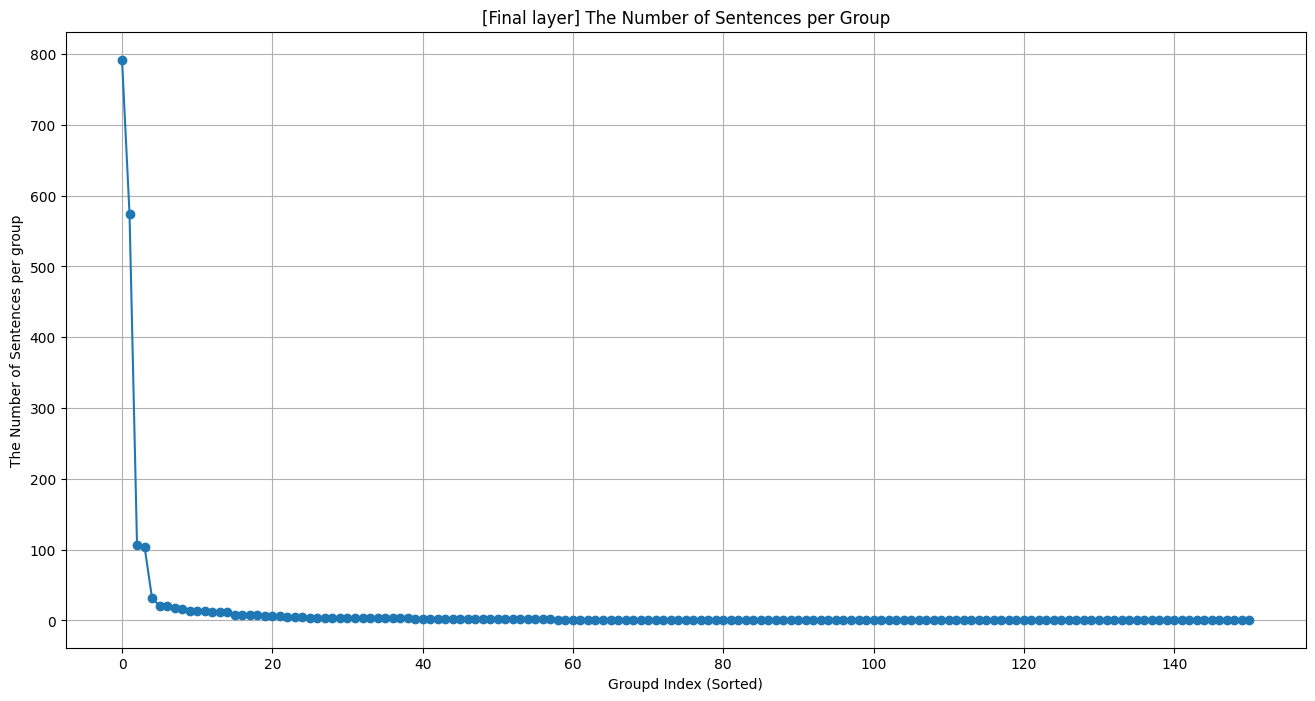

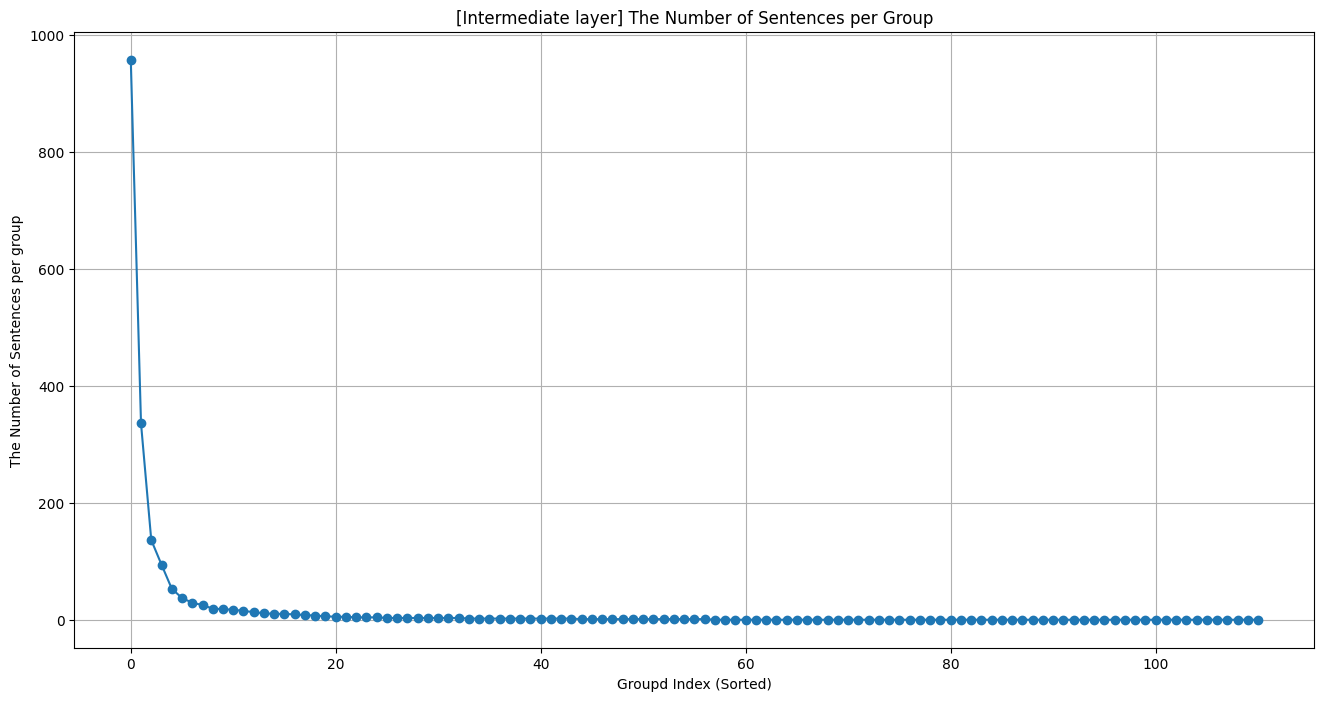

In [28]:
# Rearrange them, and plot the count in y-axis and matrix index in the x-axis.
import matplotlib.pyplot as plt

# rearrange in decreaing order (ranking)
sorted_sent_counts_final = rearrange_decreasing_order(greedy_group_counts_final)
sorted_sent_counts_inter = rearrange_decreasing_order(greedy_group_counts_inter)

def plotting(flag, sorted_sent_counts):
  if flag:
    detail = "[Final layer]"
  else:
    detail = "[Intermediate layer]"
  # x-axis
  plt.figure(figsize=(16,8))
  plt.plot(range(len(sorted_sent_counts)), sorted_sent_counts, marker='o', linestyle="-")


  plt.xlabel("Groupd Index (Sorted)")
  plt.ylabel("The Number of Sentences per group")
  plt.title(detail + " The Number of Sentences per Group")
  plt.grid(True)

  plt.show()

plotting(True, sorted_sent_counts_final)
plotting(False, sorted_sent_counts_inter)

2. Loglog Plot

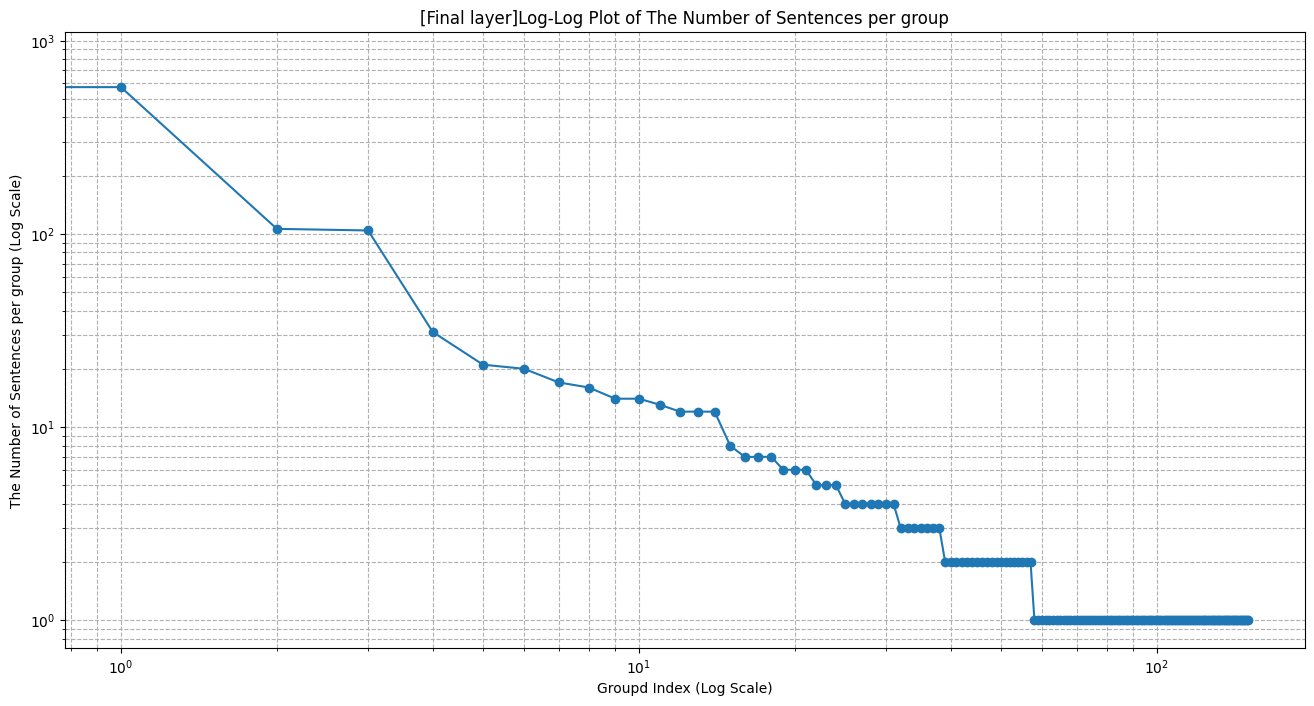

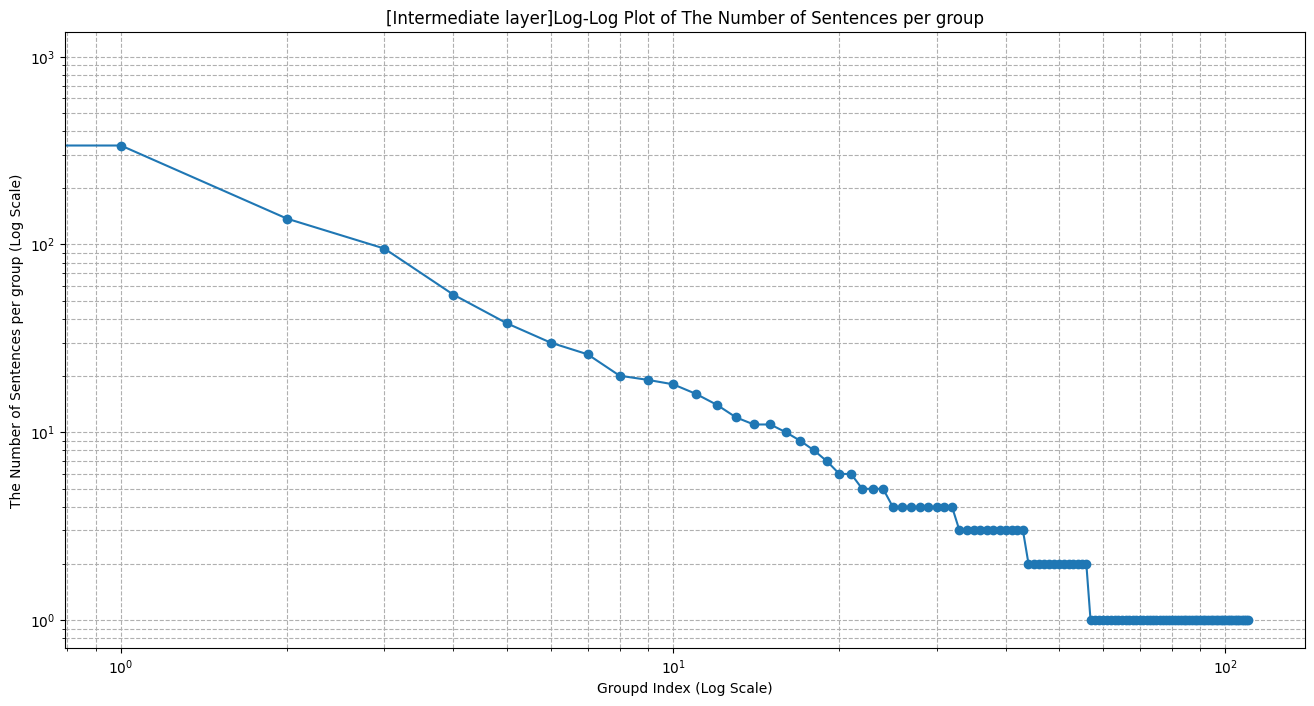

In [29]:
# Also plot the log log plot using the count matrix.
def loglog_plotting(flag, sorted_sent_counts):
  if flag:
    detail = "[Final layer]"
  else:
    detail = "[Intermediate layer]"
  plt.figure(figsize=(16,8))
  plt.loglog(range(len(sorted_sent_counts)), sorted_sent_counts, marker="o", linestyle="-")

  plt.xlabel("Groupd Index (Log Scale)")
  plt.ylabel("The Number of Sentences per group (Log Scale)")
  plt.title(detail + "Log-Log Plot of The Number of Sentences per group")
  plt.grid(True, which="both", linestyle="--")

  plt.show()

loglog_plotting(True, sorted_sent_counts_final)
loglog_plotting(False, sorted_sent_counts_inter)

3. Linear Regression

In [33]:
from scipy.stats import linregress

def linear_regression(sorted_sent_counts):
  x = np.log10(np.arange(1, len(sorted_sent_counts)+1))
  y = np.log10(sorted_sent_counts)

  # linear regression
  slope, intercept, r_val, p_val, std_err = linregress(x, y)

  # regression prediction
  y_pred = slope * x + intercept

  return x, y, slope, intercept, r_val, p_val, y_pred

In [34]:
def return_linear_regression_result(flag, sorted_sent_counts):
  if flag:
    detail = "[Final layer]"
  else:
    detail = "[Intermediate layer]"

  x, y, slope, intercept, r_val, p_val, y_pred = linear_regression(sorted_sent_counts)

  print(detail + "Linear Regression Prediction: y = slope * x + intercept")
  print(f"y ={slope:.2f}x + {intercept:.2f}")

  print(f"Linear Regression Results:")
  print(f"   - Slope: {slope:.4f}")
  print(f"   - Intercept: {intercept:.4f}")
  print(f"   - R-squared: {r_val**2:.4f}")
  print(f"   - P-value: {p_val:.4e}")

In [36]:
return_linear_regression_result(True, sorted_sent_counts_final)
print()
return_linear_regression_result(False, sorted_sent_counts_inter)

[Final layer]Linear Regression Prediction: y = slope * x + intercept
y =-1.20x + 2.40
Linear Regression Results:
   - Slope: -1.1999
   - Intercept: 2.3969
   - R-squared: 0.9227
   - P-value: 1.0412e-84

[Intermediate layer]Linear Regression Prediction: y = slope * x + intercept
y =-1.42x + 2.73
Linear Regression Results:
   - Slope: -1.4249
   - Intercept: 2.7328
   - R-squared: 0.9737
   - P-value: 6.2423e-88


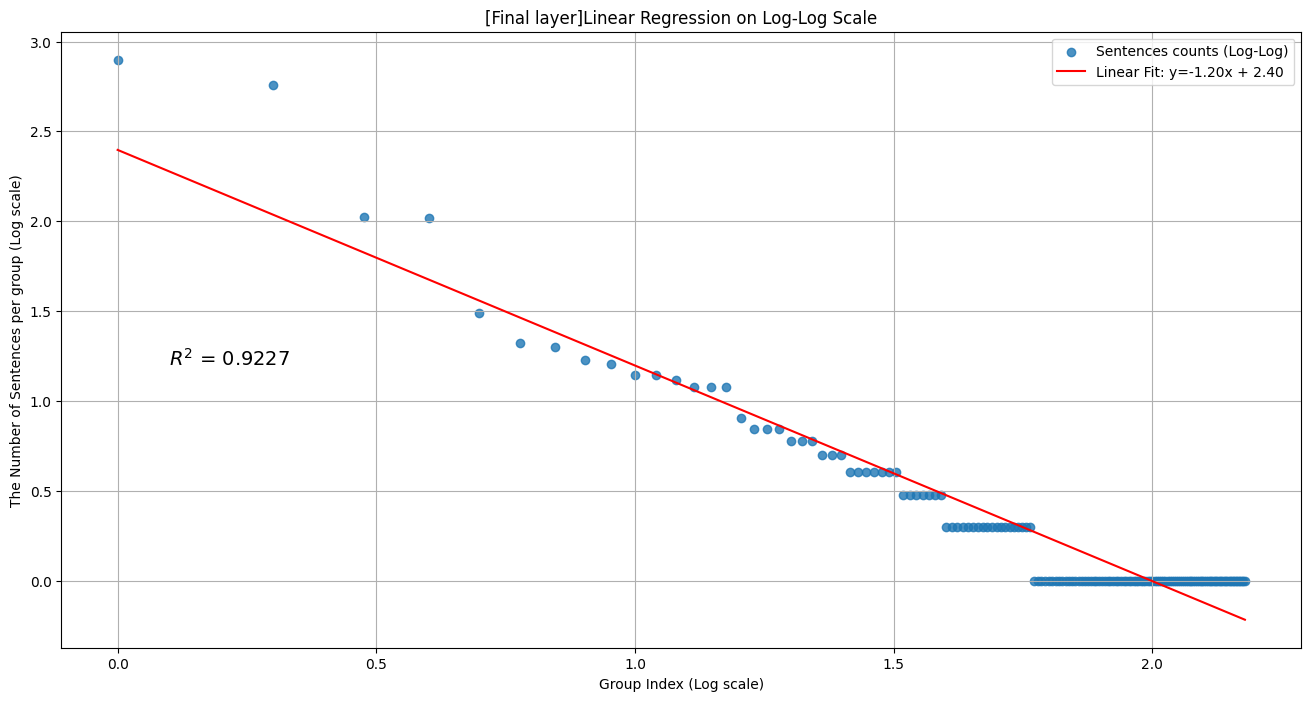

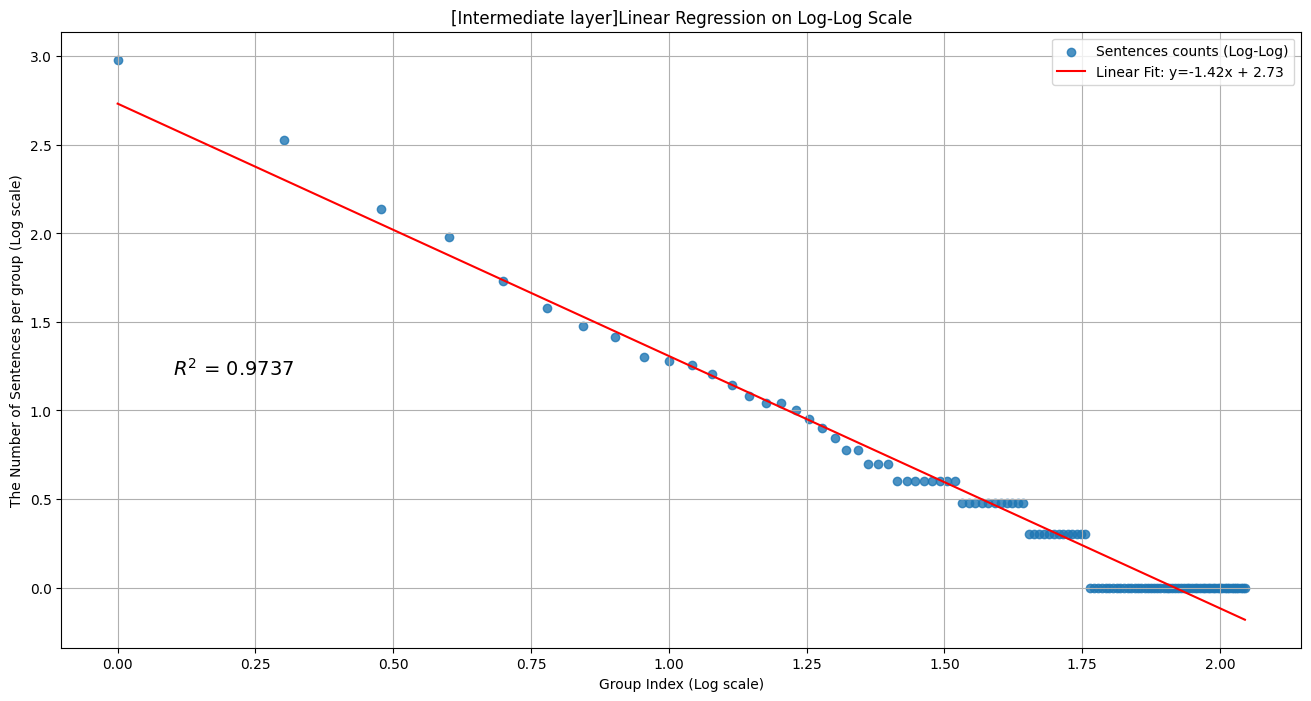

In [37]:
def linear_regression_plotting(flag, sorted_sent_counts):
  if flag:
    detail = "[Final layer]"
  else:
    detail = "[Intermediate layer]"

  x, y, slope, intercept, r_val, p_val, y_pred = linear_regression(sorted_sent_counts)

  plt.figure(figsize=(16,8))
  plt.scatter(x, y, label="Sentences counts (Log-Log)", alpha=0.8, marker="o")
  plt.plot(x, y_pred, color = "red", label=f"Linear Fit: y={slope:.2f}x + {intercept:.2f}")
  plt.text(0.1, 1.2, f"$R^2$ = {r_val**2:.4f}", fontsize=14, color="black")

  plt.xlabel("Group Index (Log scale)")
  plt.ylabel("The Number of Sentences per group (Log scale)")
  plt.title(detail + "Linear Regression on Log-Log Scale")
  plt.legend()
  plt.grid(True)

  plt.show()

linear_regression_plotting(True, sorted_sent_counts_final)
linear_regression_plotting(False, sorted_sent_counts_inter)

##Analysis of Log-Log Linear Regression Results
The log-log plots visualize the relationship between cluster indices and the number of sentences per cluster. The fitted linear regression line provides insight into how the clustering behavior follows a power-law distribution.

### Key Observations
1. Final Layer (First Plot)

- The regression slope is -1.20, indicating a moderate decay in the number of sentences per cluster.
- The R² value is 0.9227, which shows a strong linear relationship in the log-log space but with slightly more variation than the intermediate layer.
- The clusters are more spread out, suggesting that the final layer embeddings result in a more diverse grouping of sentences.

2. Intermediate Layer (Second Plot)

- The regression slope is -1.42, meaning a steeper decline in sentence count as cluster index increases.
- The R² value is 0.9737, showing a very strong fit to the linear trend, implying that the intermediate layer produces more structured and predictable clusters.
- The clustering pattern is more compact, meaning that clusters tend to have a more even distribution of sentence counts compared to the final layer.

### Interpretation
- The intermediate layer follows a clearer power-law distribution, with clusters being more evenly distributed, as indicated by the stronger R² value.
- The final layer has more outliers and higher variability, which could be due to task-specific fine-tuning effects that introduce more noise into the embeddings.
- If the goal is to obtain generalized sentence groupings, the intermediate layer seems to be the better choice, as its clusters are more structured.
- If the goal is to capture task-specific nuances, the final layer might be preferable due to its more diverse cluster structure.


### Conclusion
- The intermediate layer embeddings exhibit stronger clustering consistency, making them more suitable for applications involving broad contextual representation (e.g., semantic similarity tasks).
- The final layer embeddings create more specialized clusters, which could be beneficial for fine-tuned applications like classification tasks.